# The$\ \beta$-Hermite (Gaussian) Ensembles

Referencing paper : <i>Matrix Models for Beta Ensembles</i>, Ioana Dumitriu and Alan Edelman

- Generation of $\ \beta$-Hermite Gaussian Ensemble as in the paper
- Plot the DPP created by the matrices of this ensemble
- Finfd a dynamic version, a Dyson Brownian motion version.

## 1. Static

In [1]:
%pylab inline
from matplotlib import gridspec
from numpy.matlib import repmat
import plotly.graph_objs as go
import plotly.offline

def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

def sc_law(x,R=1):
    return 2/(pi*R**2) * np.sqrt(R**2 - x**2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def beta_Hermite_Gaussian_ensemble(dim, beta):
    diag = np.diag(np.random.randn(dim))
    u_diag_vect = np.zeros(dim-1)
    for i in range(0,dim-1):
        u_diag_vect[i] = np.sqrt(np.random.chisquare((dim-(i+1))*beta))
    u_diag = np.diag(u_diag_vect,1)
    H_b = diag + u_diag + u_diag.T
    return H_b

def gue(dim, beta, normalization=False): #beta=1 pour real et 2 pour herm
    B = np.random.randn(dim, dim)
    B_tild = np.random.randn(dim, dim)
    diag = (2/(beta))**0.5 * np.diag(np.diag(B))
    triu = (1/(beta))**0.5 * (np.triu(B,1) + 1j*(beta-1)*np.triu(B_tild,1))
    H = np.zeros((dim,dim)) + diag + triu + triu.T
    if normalization:
        H_return = (1/(N**0.5))*H
    else:
        H_return = H
    return H_return

In [3]:
# Eigenvalues sample
N = 200
eigenvalues_samples = np.linalg.eigvalsh(beta_Hermite_Gaussian_ensemble(N, 2))

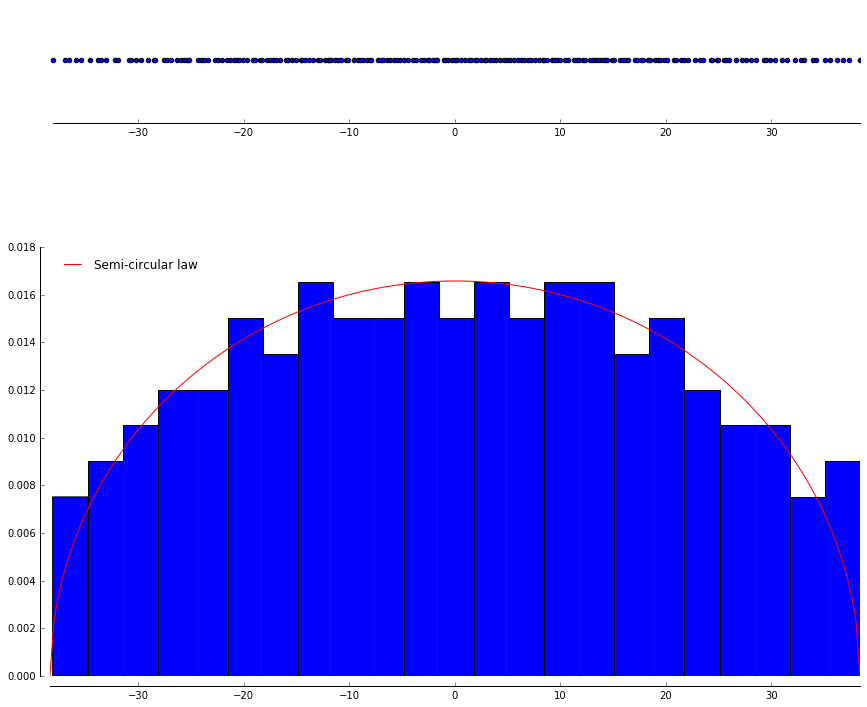

In [4]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(hspace=.5)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
ax0 = plt.subplot(gs[0])

ax0.scatter(eigenvalues_samples, np.zeros((N,)))
adjust_spines(ax0, ['bottom'])
plt.savefig('beta_hermite_eigenvalues.png', bbox_inches='tight')

# Distribution of the eigen values
# Histo
num_bins = 23
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.hist(eigenvalues_samples, num_bins, normed=1)

# Semi circle law
sc_nb_points = 200
x=np.linspace(-max(eigenvalues_samples),max(eigenvalues_samples),sc_nb_points)
ax1.plot(x,sc_law(x,R=max(eigenvalues_samples)),'red', label=r'Semi-circular law')

# Plot options
ax1.set_xlim([-max(eigenvalues_samples), max(eigenvalues_samples)])
plt.subplots_adjust(left=0.15)
ax1.legend(loc='upper left', frameon=False)

adjust_spines(ax1, ['left', 'bottom'])
plt.savefig('beta_hermite_eigenvalues.png', bbox_inches='tight')

## 2. Dynamic (classic)

In [5]:
class beta_hermite_dpp:
    def __init__(self, n_traj, n_samples, tf, beta, rescaling=False):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.dt = tf/n_samples
        self.beta = beta
        #self.dpp_matrix = np.zeros((self.n_samples, self.n_traj, self.n_traj))
        self.brownian_matrix = [np.zeros((self.n_traj, self.n_traj))]
        self.dpp_matrix = [np.zeros((self.n_traj, self.n_traj))]
        self.generate()
        self.eigen_values = np.zeros((self.n_samples, self.n_traj))
        self.diag(rescaling)

    def generate(self):
        for sample in range(self.n_samples-1):
            brownian_matrix = self.dpp_matrix[sample] + gue(self.n_traj, beta=2)*(self.dt)**0.5
            self.brownian_matrix.append(brownian_matrix)
            dpp_matrix = np.diag(np.diag(brownian_matrix))
            triu = np.triu(brownian_matrix**2, 1)
            triu_vect = triu.sum(axis=1)
            for i in range(self.n_traj-1):
                dpp_matrix[i][i+1] = triu_vect[i]
                dpp_matrix[i+1][i] = triu_vect[i]
            self.dpp_matrix.append(dpp_matrix)

    def diag(self, rescaling):
        if rescaling:
            for sample in range(1, self.n_samples):
                eigen_values = sorted(np.real( np.linalg.eigvals(self.dpp_matrix[sample]) ), reverse=True)
                self.eigen_values[sample] = np.multiply(eigen_values, 1/np.sqrt((sample)*self.dt))
                #print(1/np.sqrt((sample+1)*self.dt))
        else:
            for sample in range(1, self.n_samples):
                self.eigen_values[sample] = \
                    sorted(np.real(np.linalg.eigvals(self.dpp_matrix[sample])), reverse=True)

In [13]:
test_beta_hermite_dpp = beta_hermite_dpp(100, 100, 1, beta=2, rescaling=False)

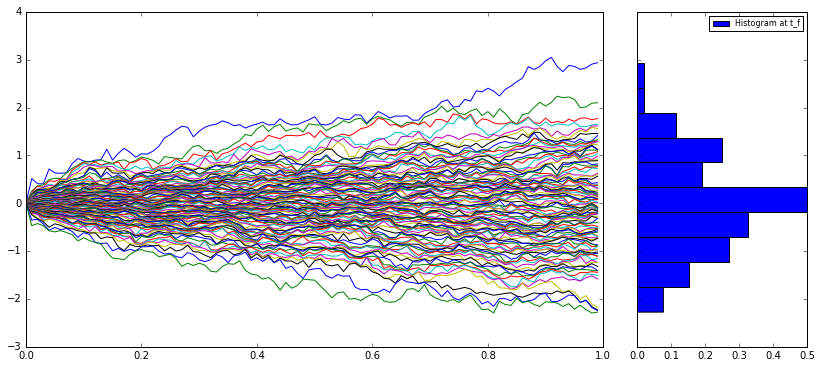

In [14]:
fig = plt.figure(1, figsize=(14, 6))
gs = GridSpec(1,4)

dpp_fig = fig.add_subplot(gs[0,0:3])
dpp_hist = fig.add_subplot(gs[0,3])

t = np.matlib.repmat(np.arange(0, test_beta_hermite_dpp.tf, test_beta_hermite_dpp.dt),test_beta_hermite_dpp.n_traj,1)
dpp_fig.plot(t.T, test_beta_hermite_dpp.eigen_values)

eigen_values_final = test_beta_hermite_dpp.eigen_values[-1]
hist = dpp_hist.hist(eigen_values_final, bins=10, normed=True, orientation='horizontal',label="Histogram at t_f")

plt.setp(dpp_hist.get_yticklabels(), visible=False)
dpp_hist.set_ylim(dpp_fig.get_ylim())

dpp_hist.legend(prop={'size':8})
plt.show()

## 2. Dynamic (rescale)

In [8]:
test_beta_hermite_dpp_rescale = beta_hermite_dpp(200, 100, 1, beta=2, rescaling=True)

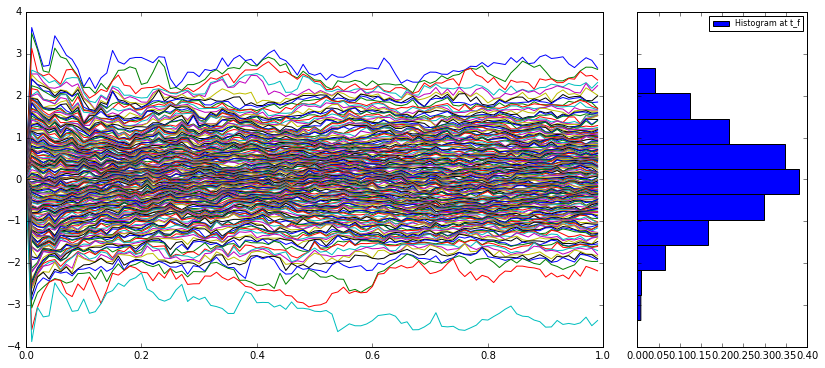

In [9]:
fig = plt.figure(1, figsize=(14, 6))
gs = GridSpec(1,4)

dpp_fig = fig.add_subplot(gs[0,0:3])
dpp_hist = fig.add_subplot(gs[0,3])

t = np.matlib.repmat(np.arange(0, test_beta_hermite_dpp_rescale.tf, test_beta_hermite_dpp_rescale.dt),test_beta_hermite_dpp_rescale.n_traj,1)
dpp_fig.plot(t.T, test_beta_hermite_dpp_rescale.eigen_values)

eigen_values_final = test_beta_hermite_dpp_rescale.eigen_values[-1]
hist = dpp_hist.hist(eigen_values_final, bins=10, normed=True, orientation='horizontal',label="Histogram at t_f")

plt.setp(dpp_hist.get_yticklabels(), visible=False)
dpp_hist.set_ylim(dpp_fig.get_ylim())

#max_abs_eigenvalue = max(eigen_values_final)
#min_abs_eigenvalue = min(eigen_values_final)
#R = (min_abs_eigenvalue-max_abs_eigenvalue)/2
#sc_nb_points = 200
#x=np.linspace(max_abs_eigenvalue, min_abs_eigenvalue, sc_nb_points)
#dpp_hist.plot(sc_law(x,R=R),x ,'red', label=r'Semi-circular law')

dpp_hist.legend(prop={'size':8})
plt.show()